In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [127]:
# Set random seed for reproducibility
np.random.seed(42)

# 1. Data Collection and Preprocessing

In [129]:
# Load the dataset (assumes flights.csv is downloaded from Kaggle)
print("Loading dataset...")
df = pd.read_csv(r"C:\Users\SMART TECH\Desktop\AppliedNLPMaterial-master\DataSets\flights.csv")

# Sample a subset of the data (e.g., 100,000 rows)
sample_size = 100000  # Adjust as needed (e.g., 500000 for larger sample)
df = df.sample(n=sample_size, random_state=42)

Loading dataset...


In [130]:
# Exploratory Data Analysis (EDA)
print("Dataset Shape:", df.shape)
print("\nMissing Values:\n", df.isnull().sum())
print("\nData Types:\n", df.dtypes)

Dataset Shape: (100000, 31)

Missing Values:
 YEAR                       0
MONTH                      0
DAY                        0
DAY_OF_WEEK                0
AIRLINE                    0
FLIGHT_NUMBER              0
TAIL_NUMBER              260
ORIGIN_AIRPORT             0
DESTINATION_AIRPORT        0
SCHEDULED_DEPARTURE        0
DEPARTURE_TIME          1481
DEPARTURE_DELAY         1481
TAXI_OUT                1538
WHEELS_OFF              1538
SCHEDULED_TIME             0
ELAPSED_TIME            1805
AIR_TIME                1805
DISTANCE                   0
WHEELS_ON               1602
TAXI_IN                 1602
SCHEDULED_ARRIVAL          0
ARRIVAL_TIME            1602
ARRIVAL_DELAY           1805
DIVERTED                   0
CANCELLED                  0
CANCELLATION_REASON    98446
AIR_SYSTEM_DELAY       81646
SECURITY_DELAY         81646
AIRLINE_DELAY          81646
LATE_AIRCRAFT_DELAY    81646
WEATHER_DELAY          81646
dtype: int64

Data Types:
 YEAR                     int

In [131]:
# Define delay threshold (arrival delay > 15 minutes)
df['DELAYED'] = (df['ARRIVAL_DELAY'] > 15).astype(int)
print("\nClass Distribution in Sample:\n", df['DELAYED'].value_counts(normalize=True))



Class Distribution in Sample:
 DELAYED
0    0.82308
1    0.17692
Name: proportion, dtype: float64


In [132]:
# Compare class distribution with full dataset
full_df = pd.read_csv(r"C:\Users\SMART TECH\Desktop\AppliedNLPMaterial-master\DataSets\flights.csv", usecols=['ARRIVAL_DELAY'])
full_df['DELAYED'] = (full_df['ARRIVAL_DELAY'] > 15).astype(int)
print("\nClass Distribution in Full Dataset:\n", full_df['DELAYED'].value_counts(normalize=True))
del full_df  # Free memory




Class Distribution in Full Dataset:
 DELAYED
0    0.824113
1    0.175887
Name: proportion, dtype: float64


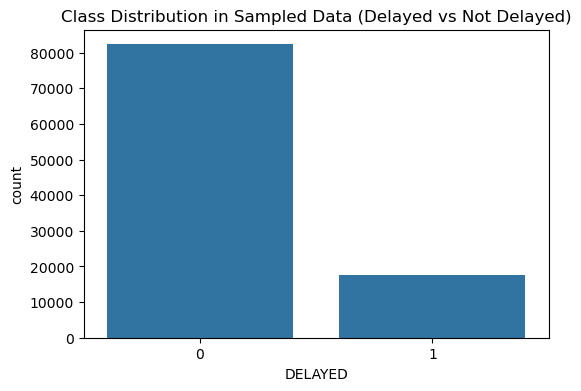

In [133]:
# Visualize class imbalance in sample
plt.figure(figsize=(6, 4))
sns.countplot(x='DELAYED', data=df)
plt.title('Class Distribution in Sampled Data (Delayed vs Not Delayed)')
plt.show()

# Handle missing values

In [135]:
# Drop columns with high missing values or irrelevant features
columns_to_drop = ['CANCELLATION_REASON', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 
                   'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 
                   'TAIL_NUMBER', 'DIVERTED', 'CANCELLED']
df = df.drop(columns=columns_to_drop)

print("Dataset Shape:", df.shape)

Dataset Shape: (100000, 23)


In [136]:
print("Dataset Shape:", df.shape)

Dataset Shape: (100000, 23)


### Median Imputation for numerical values

In [138]:
df['ARRIVAL_DELAY'] = df['ARRIVAL_DELAY'].fillna(df['ARRIVAL_DELAY'].median())
df['DEPARTURE_DELAY'] = df['DEPARTURE_DELAY'].fillna(df['DEPARTURE_DELAY'].median())
df['ARRIVAL_TIME'] = df['ARRIVAL_TIME'].fillna(df['ARRIVAL_TIME'].median())
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].fillna(df['DEPARTURE_TIME'].median())
df['AIR_TIME'] = df['AIR_TIME'].fillna(df['AIR_TIME'].median())
df['ELAPSED_TIME'] = df['ELAPSED_TIME'].fillna(df['ELAPSED_TIME'].median())


In [139]:
# Drop any remaining rows with missing values
df = df.dropna()

In [140]:
# Extract time of day from DEPARTURE_TIME
def get_time_of_day(time):
    hour = int(time // 100)
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 22:
        return 'Evening'
    else:
        return 'Night'

df['TIME_OF_DAY'] = df['DEPARTURE_TIME'].apply(get_time_of_day)

In [141]:
# Extract season from MONTH
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df['SEASON'] = df['MONTH'].apply(get_season)

In [142]:
# Categorize distance
df['DISTANCE_CATEGORY'] = pd.cut(df['DISTANCE'], 
                                bins=[0, 500, 1500, float('inf')], 
                                labels=['Short', 'Medium', 'Long']).astype('category')

In [143]:
# Encode high-cardinality categorical variables with LabelEncoder
# Apply one-hot encoding to all categorical variables
categorical_cols = ['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 
                   'TIME_OF_DAY', 'SEASON', 'DISTANCE_CATEGORY']
df = pd.get_dummies(df, columns=categorical_cols, prefix=categorical_cols, dtype='int8')

In [ ]:
# Correlation analysis
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()